In [1]:
# increase width of the notebook display in browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import itertools
import os

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('dark')

from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.externals import joblib

%matplotlib inline

# Load the credit card transactions data

In [3]:
from utils import load_data

df = load_data.load_fraud_data()
# Check the first 10 observations of the dataset
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [4]:
# Isolate the target variable
y_true = df['Class']

# Keep only the independent features in a new DataFrame
df_feat = df.drop(['Class'], axis=1)
assert 'Class' not in df_feat.columns.values

df_feat.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68


# Exploratory analysis

### Overview of the dataset

In [5]:
from utils import utils

CLASS_NAMES = ['normal', 'fraudulent']

utils.summary_statistics(df_feat, y_true, class_names=CLASS_NAMES)

No of transactions: 284807
No of features/variables: 30
No of classes: 2

No of fraudulent transactions (class = 1): 492
No of normal transactions (class = 0): 284315

Class Distribution: 578:1


### Summary Statistics

In [6]:
# summary statistics for each feature
display(df_feat.describe())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,6.406703e-16,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


### Class Distribution

,class_proportion
0,0.9983
1,0.0017


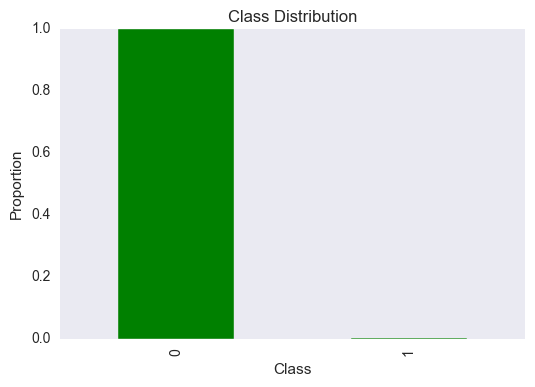

In [7]:
display(y_true.value_counts(normalize=True).round(4).to_frame(name="class_proportion"))
ax = y_true.value_counts(normalize=True).plot(kind='bar', color='green', title='Class Distribution')
ax.set_xlabel("Class")
ax.set_ylabel("Proportion")

### Pairplot - Distribution and Relationship between quantitative features

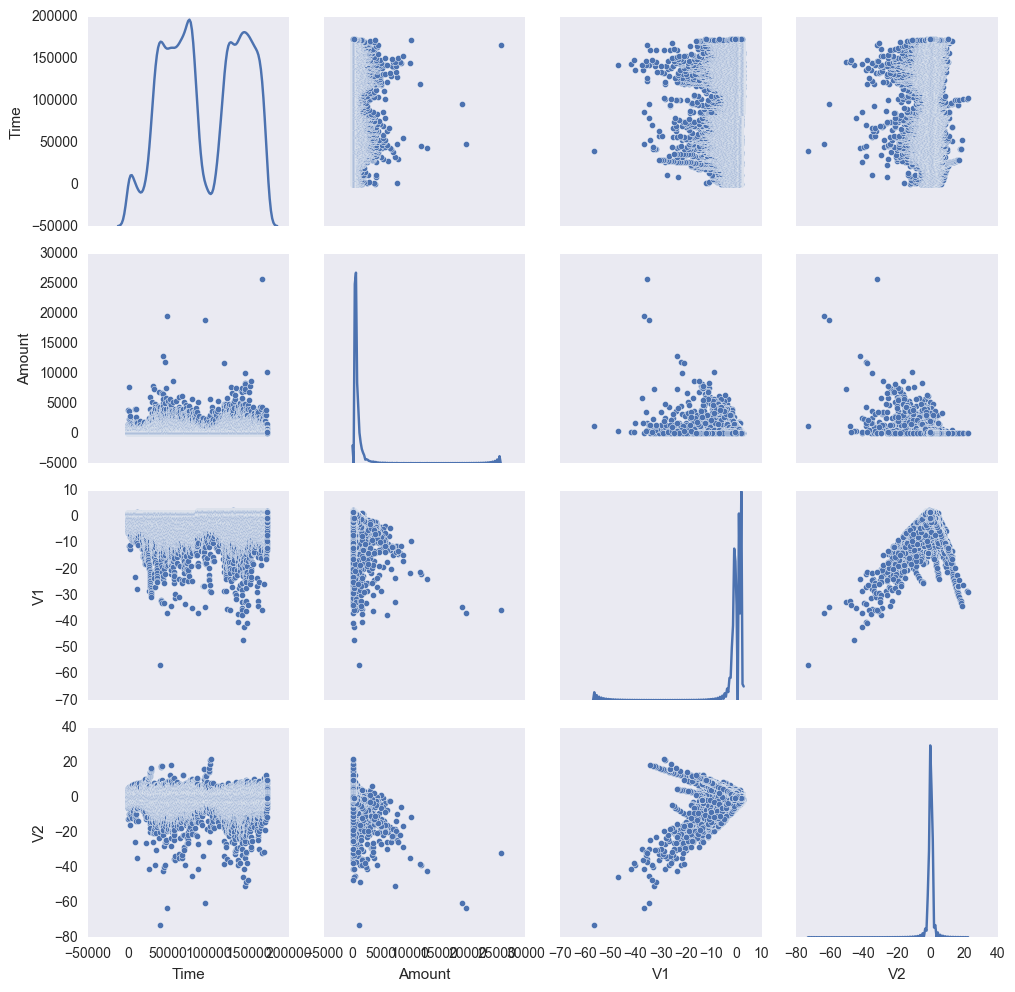

In [8]:
# WARNING: takes several minutes to run
sns.pairplot(data=df_feat[['Time', 'Amount', 'V1', 'V2']], diag_kind='kde')

### Q-Q plot - Check if all PCA variables are normally distributed

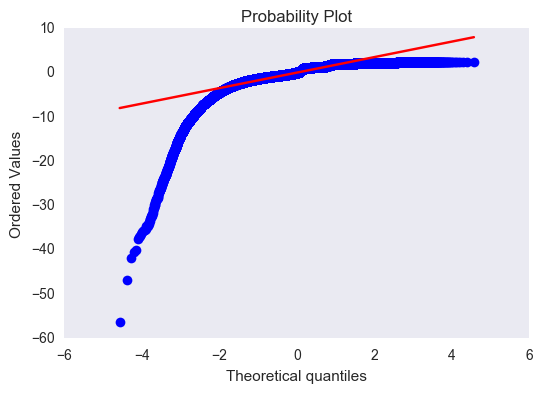

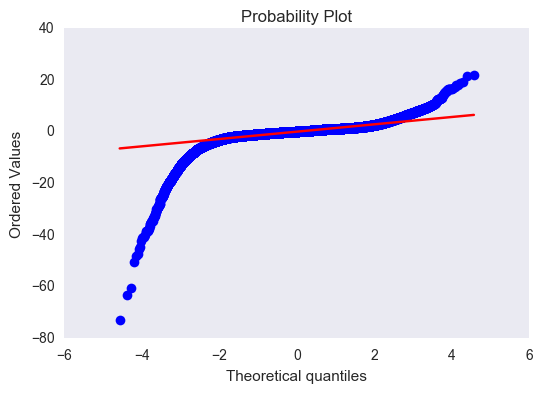

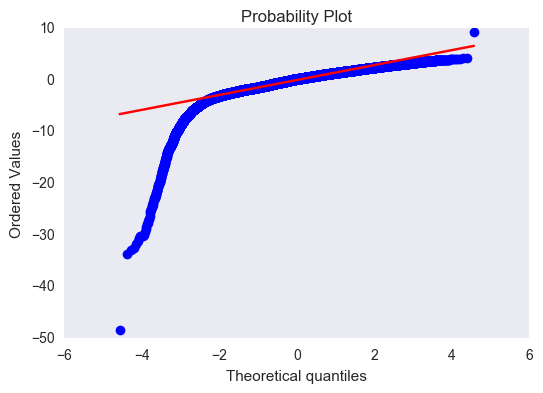

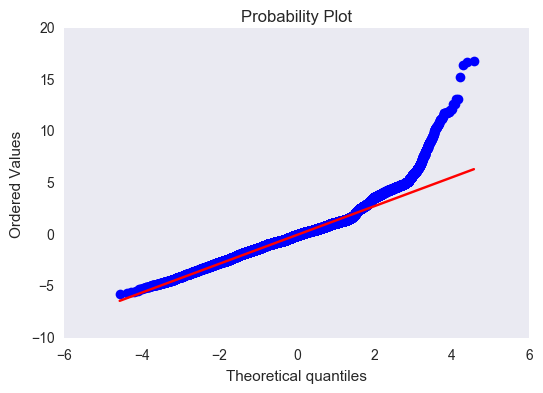

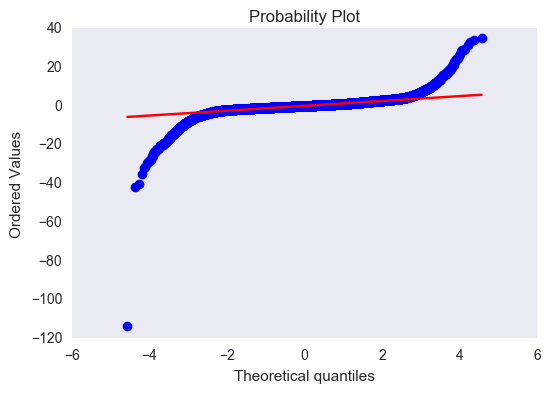

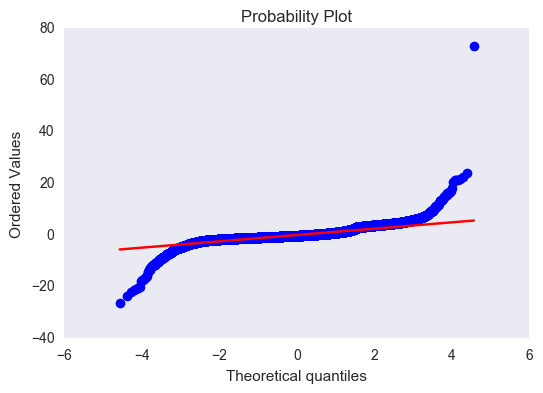

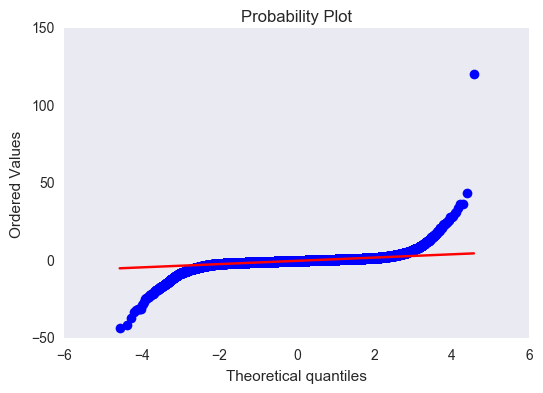

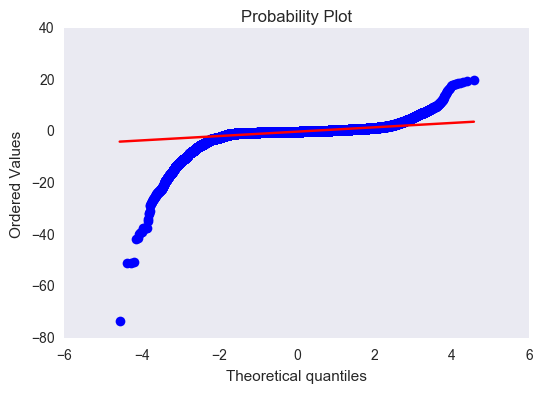

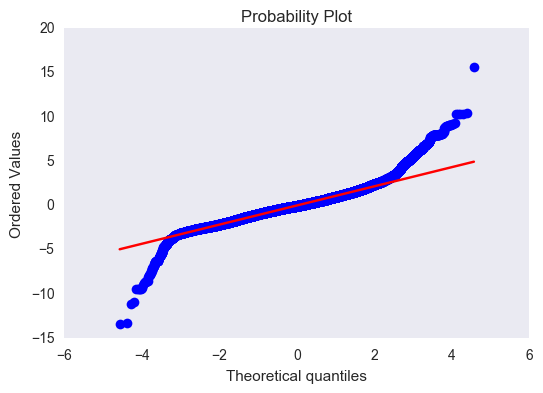

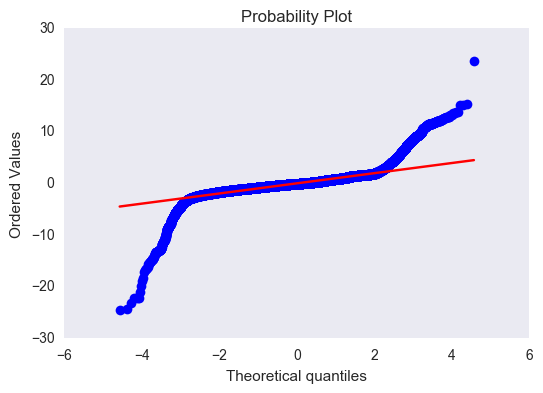

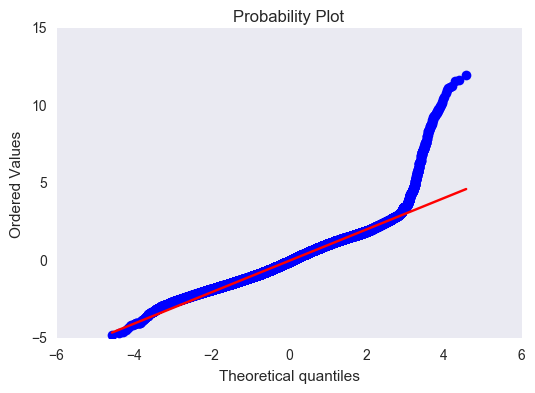

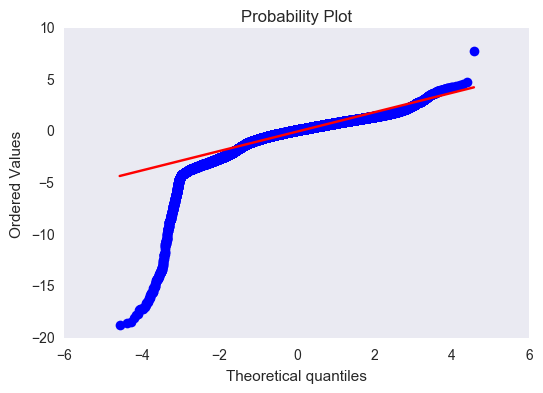

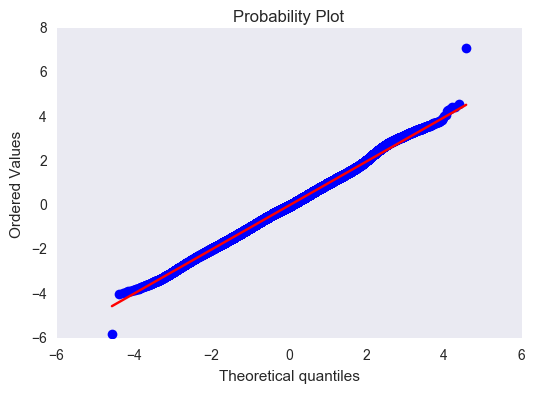

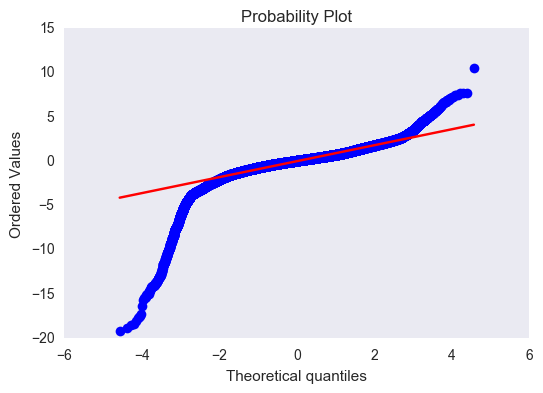

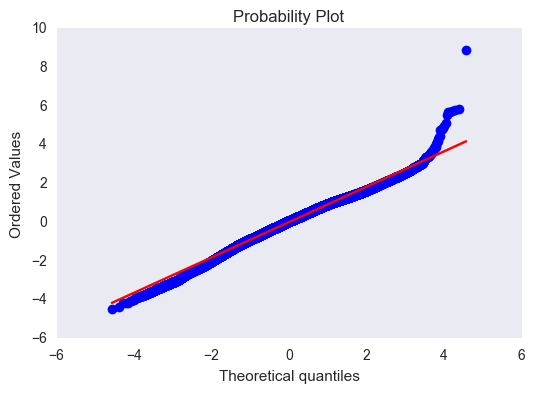

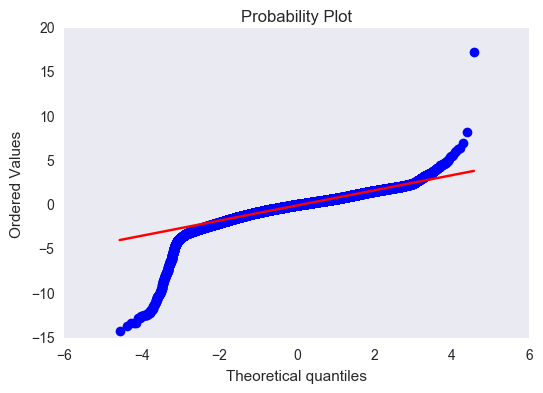

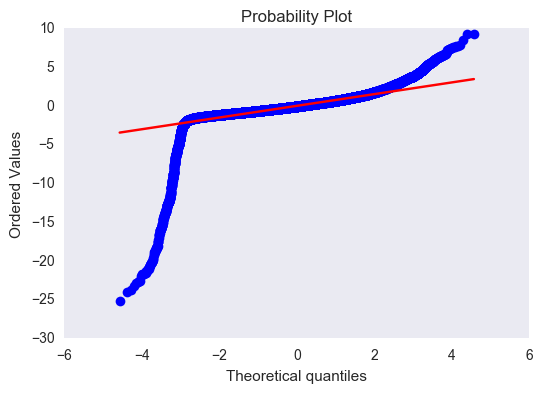

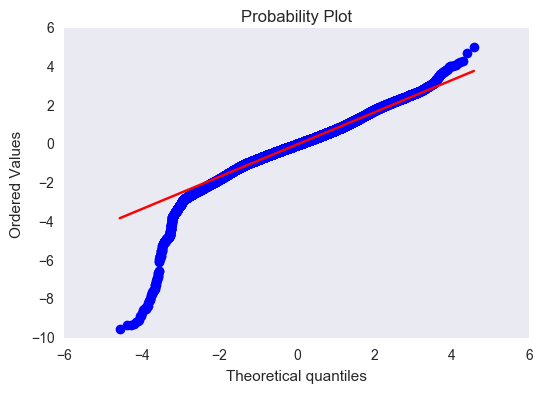

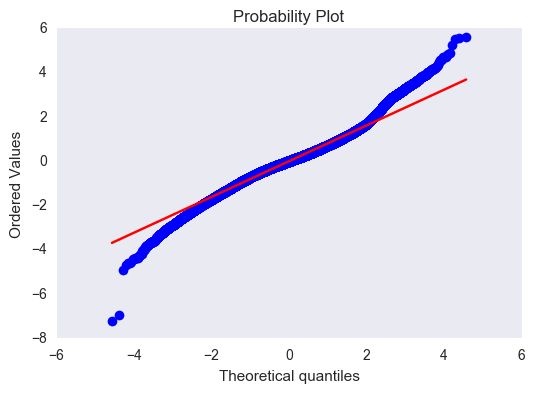

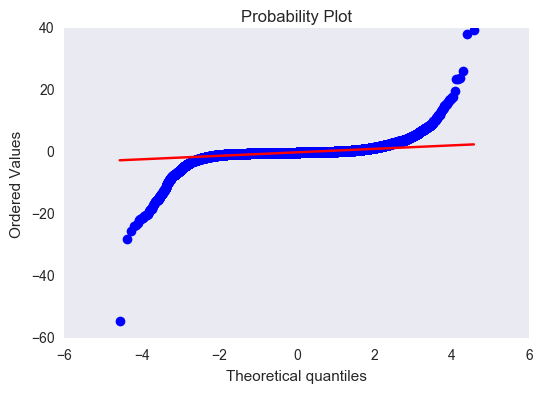

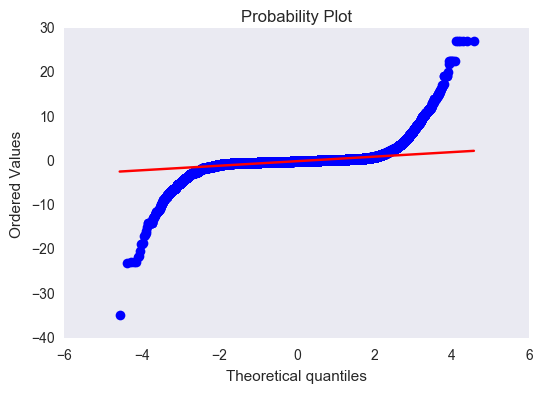

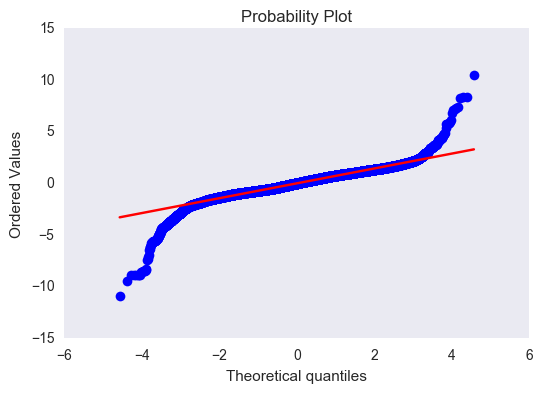

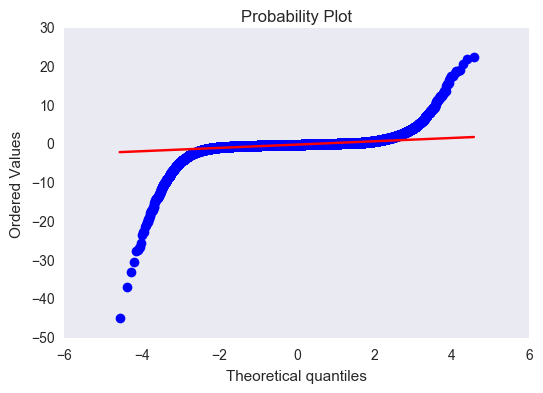

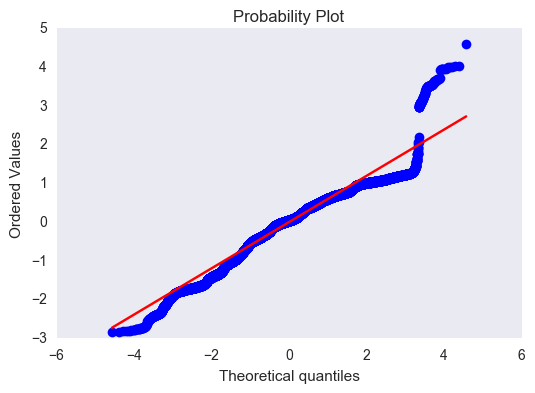

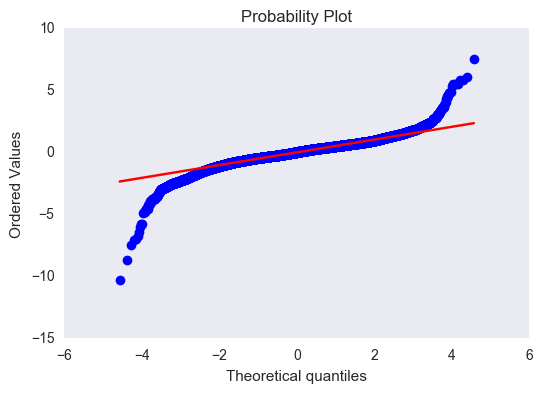

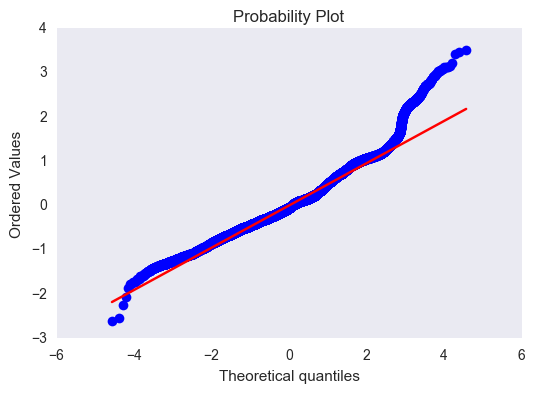

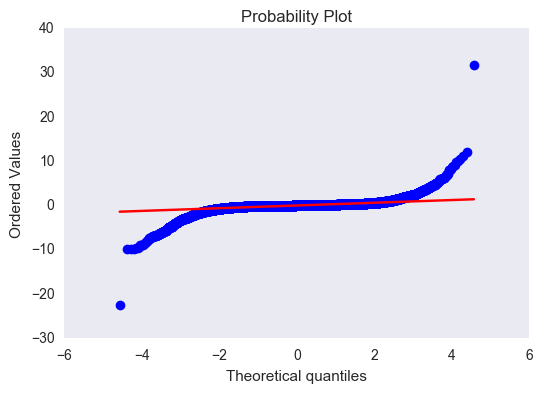

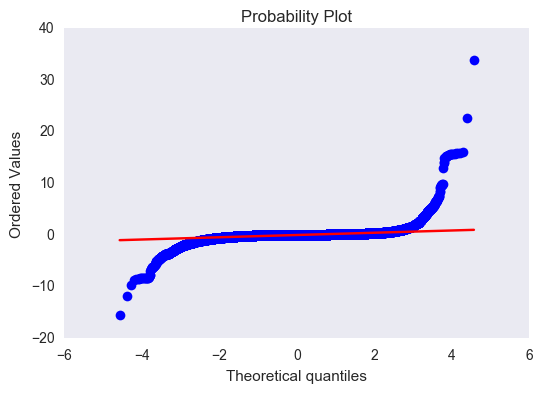

In [10]:
from scipy import stats

for feat in df_feat.drop(['Time', 'Amount'], axis=1).columns.values:
    stats.probplot(df[feat], dist="norm", plot=plt)
    plt.show()

### Heatmap - Confirm all PCA variables are uncorrelated

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Time,1.00,0.12,-0.01,-0.42,-0.11,0.17,-0.06,0.08,-0.04,-0.01,...,-0.05,0.04,0.14,0.05,-0.02,-0.23,-0.04,-0.01,-0.01,-0.01
V1,0.12,1.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,...,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.23
V2,-0.01,0.00,1.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,...,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.53
V3,-0.42,-0.00,0.00,1.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,...,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.21
V4,-0.11,0.00,-0.00,-0.00,1.00,-0.00,-0.00,0.00,0.00,0.00,...,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.10
V5,0.17,0.00,-0.00,-0.00,-0.00,1.00,0.00,-0.00,0.00,0.00,...,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.39
V6,-0.06,0.00,0.00,0.00,-0.00,0.00,1.00,0.00,-0.00,0.00,...,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.22
V7,0.08,0.00,0.00,0.00,0.00,-0.00,0.00,1.00,-0.00,0.00,...,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.40
V8,-0.04,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,1.00,0.00,...,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.10
V9,-0.01,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.04


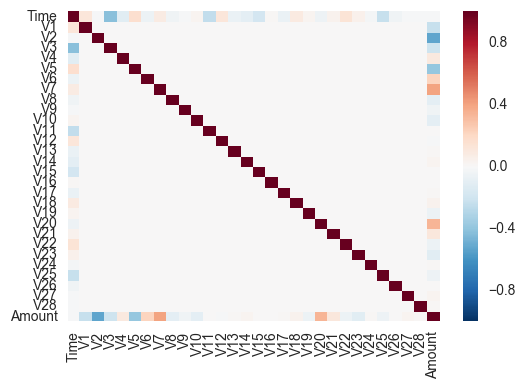

In [11]:
corr_matrix = df_feat.corr(method='pearson', min_periods=1).round(2)
display(corr_matrix)
sns.heatmap(corr_matrix)

As expected, the PCA features are uncorrelated. The remaining two features (Time and Amount) do not seem to be highly correlated with any other feature.

### Boxplot - check the presence of outliers (Time and Amount features)

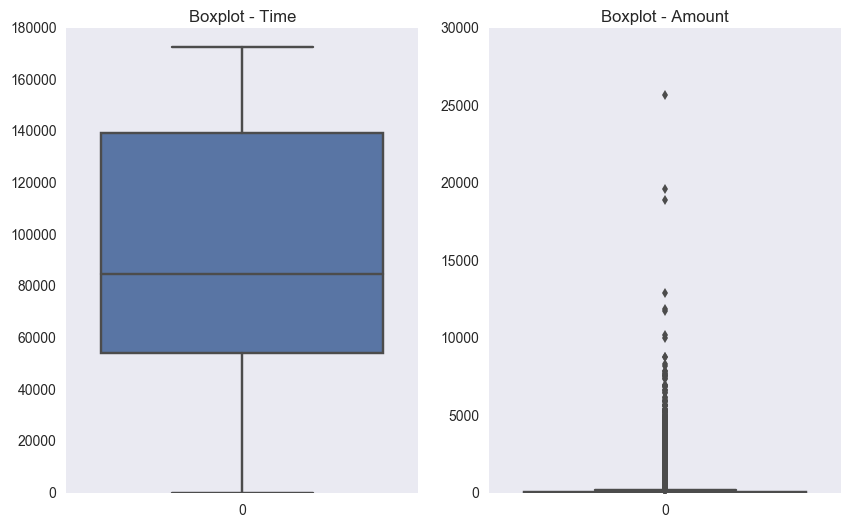

In [12]:
fig, axs = plt.subplots(1,2, figsize=(10,6))

for ax, feat in zip(axs, ['Time', 'Amount']):
    p = sns.boxplot(data=df[feat], ax=ax)
    p.set_title('Boxplot - {}'.format(feat))

From the boxplots, we can deduce that the _Amount_ feature has a highly skewed distribution with many outliers, while the distribution of the _Time_ feature is right skewed with no outliers.

# Train and evaluate a classification model

In [13]:
N_FOLDS = 10
THRESHOLD = 0.5
SEED = 42

# Generate a training set and test set using stratified sampling (i.e., the proportion of 
# fraudulent and normal transactions is equivalent in both sets)
X_train, X_test, y_train, y_test = train_test_split(df_feat, y_true, test_size=0.25, stratify=y_true, random_state=SEED)
print('Finished train/test splitting')

# Split the training data using cross-validation
folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED).split(X_train, y_train)
print('Finished cross-validation splitting')

Finished train/test splitting
Finished cross-validation splitting


### Dummy Classifier - for comparison purposes

In [14]:
# This dummy classifier generates predictions by respecting the training set’s class distribution.
dummy_strat = DummyClassifier(strategy='stratified', random_state=SEED)
dummy_strat.fit(X_train, y_train)

# This dummy classifier always predicts the most frequent class in the training set (i.e., 0 or 'normal' transactions)
dummy_most_freq = DummyClassifier(strategy='most_frequent', random_state=SEED)
dummy_most_freq.fit(X_train, y_train)

# Store the dummy classifiers predictions on the test set in a DataFrame
dummy_preds = pd.DataFrame({"stratified_dummy": dummy_strat.predict(X_test), 
                            "most_freq_dummy": dummy_most_freq.predict(X_test)})
dummy_preds.head(10)

dummy_strat_dist = Counter(dummy_preds.stratified_dummy)
dummy_most_freq_dist = Counter(dummy_preds.most_freq_dummy)

print('Stratified Dummy Classifier:\nNo of normal transactions predicted: {}\nNo of fraudulent transactions predicted: {}'.format(dummy_strat_dist[0], dummy_strat_dist[1]))
print('\nMost Frequent Dummy Classifier:\nNo of normal transactions predicted: {}\nNo of fraudulent transactions predicted: {}'.format(dummy_most_freq_dist[0], dummy_most_freq_dist[1]))

Stratified Dummy Classifier:
No of normal transactions predicted: 71083
No of fraudulent transactions predicted: 119

Most Frequent Dummy Classifier:
No of normal transactions predicted: 71202
No of fraudulent transactions predicted: 0


### Experiment 1  - Train a Random Forest Classifier with default parameters

In [16]:
import logging

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline

fmt = "%(asctime)s\t%(module)s.%(funcName)s (line %(lineno)d)\t%(levelname)s : %(message)s"
logging.basicConfig(level=logging.INFO, format=fmt)

CLF = RandomForestClassifier(random_state=SEED, n_jobs=-1)
pipe_1 = make_pipeline(SelectFromModel(estimator=CLF, threshold='median'), 
                      CLF)
logging.info('Training a model')
pipe_1.fit(X_train, y_train)

logging.info('Predicting on test set')
pipe_1_preds = pipe_1.predict_proba(X_test)[:,1]

INFO:root:Training a model
INFO:root:Predicting on test set


             precision    recall  f1-score   support

     normal       1.00      1.00      1.00     71079
 fraudulent       0.94      0.81      0.87       123

avg / total       1.00      1.00      1.00     71202

ROC AUC: 0.906
Matthews Correlation Coefficient: 0.876
Cohen's Kappa: 0.873
False Positive Rate: 0.000
False Negative Rate: 0.187


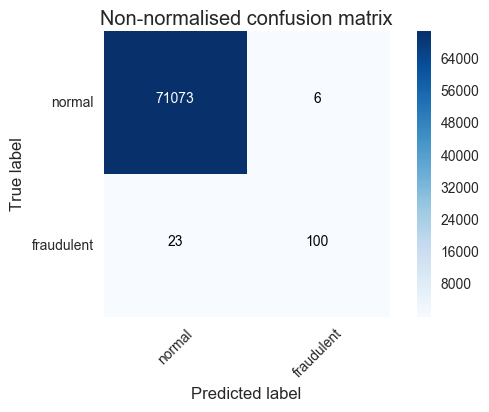

In [83]:
utils.print_report(y_test.values, pipe_1_preds >= THRESHOLD, class_names=CLASS_NAMES, normalise=False)

TBC - WIP